# Introduction to Data Science, Lab 6 (10/21)
- Support Vector Classification with different kernels (linear, rbf, polynomial);
- Voting patterns revisited.

### *Hard-margin vs. Soft-margin SVM*
Recall that there are two versions of Support Vector Machines: hard-margin and soft-margin. The former only applies to linearly separable data (or requires a kernel transformation of the feature space to satisfy linear separability) because hard-margin SVM assumes no training misclassifications. On the other hand, soft-margin SVM allows for misclassifications and is sometimes more desirable than hard-margin SVM even for perfectly separable data (in favor of reduced model complexity). The optimization problem of soft-margin SVM is

$$
\min_{w,b} \frac{1}{2}\lVert w\rVert^2+C\sum_{i=1}^{n}\xi_i\:\:\:\text{subject to}\:\:\:y_i(w_ix_i+b)\geq 1-\xi_i\:\text{ and }\:\xi_i\geq 0 \:\:\:\text{for all}\:\:\:i\in[n],
$$

where $\xi_i$ are called *slackness variables* and $C$ is the penalty associated with margin violation.
The ```scikit-learn``` library only implements the soft-margin SVM. However, it should still possible to "simulate" the hard-margin version by selecting a sufficiently large $C$, which will result in margin violations outweighing regularization and making them unacceptable for the optimal solution (more later).

First, let's fit an out-of-the box SVM from ```scikit-learn``` (with linear kernel) and understand the model, its  parameters, attributes and methods.

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Visualization of the SVM decision boundary and support vectors:
def visualize_svm(model,data,target,support_vectors=False,colors=['blue','red'],axis=None,margins=False):
    x_min,x_max,y_min,y_max=min(data[:,0]),max(data[:,0]),min(data[:,1]),max(data[:,1])
    xs,ys=np.meshgrid(np.arange(0.8*x_min,1.2*x_max,0.003*(x_max-x_min)),np.arange(0.8*y_min,1.2*y_max,0.003*(y_max-y_min)))
    predictions=model.predict([[x,y] for x,y in zip(xs.reshape(-1),ys.reshape(-1))])
    predictions=predictions.reshape(xs.shape)
    data_color=np.array([colors[1] if p>0 else colors[0] for p in target])
    if axis:
        axis.contourf(xs,ys,predictions.reshape(xs.shape),levels=1,colors=colors,alpha=0.2)
        axis.contour(xs,ys,predictions.reshape(xs.shape),levels=1,colors=['k'])
        axis.scatter(data[:,0],data[:,1],color=data_color)
        axis.set_xlim((0.8*x_min,1.2*x_max))
        axis.set_ylim((0.8*y_min,1.2*y_max))
        if margins:
            margin=1/np.linalg.norm(model.coef_[0])
            cos_alpha=model.coef_[0][1]/np.sqrt(model.coef_[0][1]**2+model.coef_[0][0]**2)
            axis.plot([-100,100],[(100*model.coef_[0][0]-model.intercept_)/model.coef_[0][1]-margin/cos_alpha,(-100*model.coef_[0][0]-model.intercept_)/model.coef_[0][1]-margin/cos_alpha],linestyle='dashed',color='k')
            axis.plot([-100,100],[(100*model.coef_[0][0]-model.intercept_)/model.coef_[0][1]+margin/cos_alpha,(-100*model.coef_[0][0]-model.intercept_)/model.coef_[0][1]+margin/cos_alpha],linestyle='dashed',color='k')
    else:
        plt.contourf(xs,ys,predictions.reshape(xs.shape),levels=1,colors=colors,alpha=0.2)
        plt.contour(xs,ys,predictions.reshape(xs.shape),levels=1,colors=['k'])
        plt.scatter(data[:,0],data[:,1],color=data_color)
        plt.xlim((0.8*x_min,1.2*x_max))
        plt.ylim((0.8*y_min,1.2*y_max))
        if margins:
            margin=1/np.linalg.norm(model.coef_[0])
            cos_alpha=model.coef_[0][1]/np.sqrt(model.coef_[0][1]**2+model.coef_[0][0]**2)
            plt.plot([-100,100],[(100*model.coef_[0][0]-model.intercept_)/model.coef_[0][1]-margin/cos_alpha,(-100*model.coef_[0][0]-model.intercept_)/model.coef_[0][1]-margin/cos_alpha],linestyle='dashed',color='k')
            plt.plot([-100,100],[(100*model.coef_[0][0]-model.intercept_)/model.coef_[0][1]+margin/cos_alpha,(-100*model.coef_[0][0]-model.intercept_)/model.coef_[0][1]+margin/cos_alpha],linestyle='dashed',color='k')
    if support_vectors:
        svs=np.array(model.support_vectors_)
        if axis:
            axis.scatter(svs[:,0],svs[:,1],color="none",edgecolor='k',s=150)
        else:
            plt.scatter(svs[:,0],svs[:,1],color="none",edgecolor='k',s=150)
            plt.show()

### *SVM with Linear Kernel*

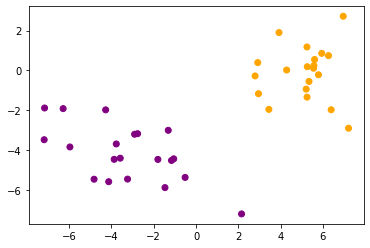

In [3]:
# Generate two Gaussian "blobs" (linearly separable):
from sklearn.datasets import make_blobs
Xs,ys=make_blobs(n_samples=40,n_features=2,centers=[[5,0],[-3,-4]],cluster_std=[1.5,1.8])
ys=ys*2-1
colors=['orange' if y<0 else 'purple' for y in ys]
plt.scatter(Xs[:,0],Xs[:,1],color=colors)
plt.show()

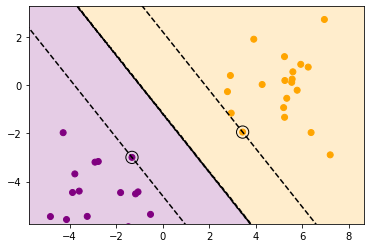

In [4]:
# Fit the standard SVC and visualize:
from sklearn.svm import SVC
model=SVC(C=1,kernel='linear') 
model.fit(Xs,ys)
visualize_svm(model,Xs,ys,True,['orange','purple'],axis=False,margins=True)

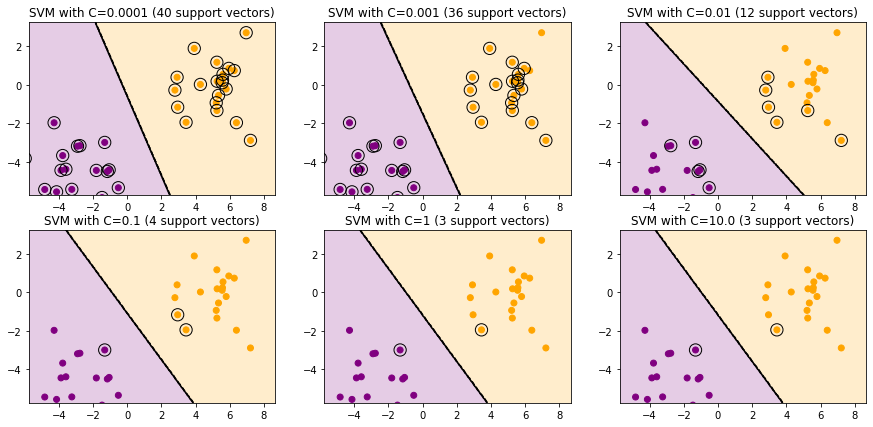

In [5]:
# Vary the value of C:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(15,7))
cs=[1e-4,1e-3,1e-2,1e-1,1,1e1]
models={}
for i,c in enumerate(cs):
    models[c]=SVC(C=c,kernel='linear')
    models[c].fit(Xs,ys)
    visualize_svm(models[c],Xs,ys,True,['orange','purple'],axes[i//3,i%3],margins=False)
    axes[i//3,i%3].set_title(f"SVM with C={c} ({len(models[c].support_vectors_)} support vectors)")

What are support vectors in soft-margin SVM and why are there fewer of them for smaller C? What can we say about the margins of the above models?

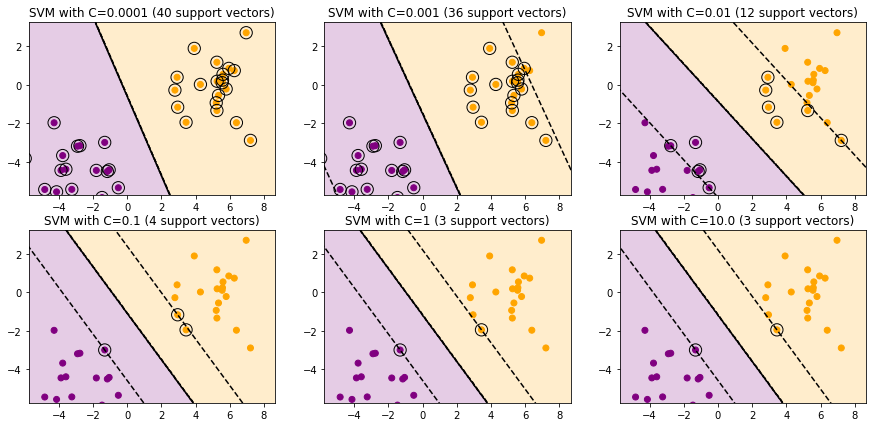

In [6]:
# Now, plot the margins:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(15,7))
for i,c in enumerate(cs):
    visualize_svm(models[c],Xs,ys,True,['orange','purple'],axes[i//3,i%3],margins=True)
    axes[i//3,i%3].set_title(f"SVM with C={c} ({len(models[c].support_vectors_)} support vectors)")

Indeed, support vectors are those points $x_i$ such that the corresponding Lagrange multiplier $\alpha^{*}_i\ne 0$ associated with the constraint $1-y_i(w^{*}x_i+b^{*})=\xi^{*}_i$, where $\xi^{*}_i$ is the *slackness* of a point $x_i$ (which is positive if and only if $x_i$ violates the margin, i.e. lies within it). In DS-GA 1003, you will derive that $\alpha^{*}_i\ne 0$ is equivalent to $\xi_i\ne 0$, meaning that the support vectors ($\alpha_i\ne 0$) are exactly those points $x_i$ within the margin ($\xi_i\ne 0$).

In [7]:
# Compute the number of points within the margins (directly):
tolerance=1e-3
for c in cs:
    w_norm=np.linalg.norm(models[c].coef_[0])
    dists=[np.abs(np.dot(models[c].coef_[0],x)+models[c].intercept_)/np.sqrt(np.dot(models[c].coef_[0],models[c].coef_[0])) for x in Xs]
    n=len(np.where(dists<=1/w_norm+tolerance)[0])
    print(f"SVM with C={c:.0e} has margin of {2/w_norm:.6f} with {n} points within the margin")

SVM with C=1e-04 has margin of 107.755006 with 40 points within the margin
SVM with C=1e-03 has margin of 12.738784 with 36 points within the margin
SVM with C=1e-02 has margin of 7.155704 with 10 points within the margin
SVM with C=1e-01 has margin of 4.458593 with 4 points within the margin
SVM with C=1e+00 has margin of 4.336605 with 3 points within the margin
SVM with C=1e+01 has margin of 4.336605 with 3 points within the margin


In [8]:
# Compute the number of points within the margins (via slackness):
for c in cs:
    slackness=[1-y*(np.dot(models[c].coef_[0],x)+models[c].intercept_) for x,y in zip(Xs,ys)]
    n_slacking=len(np.where(np.array(slackness)>-tolerance)[0])
    print(f"SVM with C={c:.0e} had {n_slacking} slacking datapoints")

SVM with C=1e-04 had 40 slacking datapoints
SVM with C=1e-03 had 36 slacking datapoints
SVM with C=1e-02 had 12 slacking datapoints
SVM with C=1e-01 had 4 slacking datapoints
SVM with C=1e+00 had 3 slacking datapoints
SVM with C=1e+01 had 3 slacking datapoints


### *SVM with RBF Kernel*
Recall from the lecture that a *radial-basis-kernel* is defined as $K(x_1,x_2)=\exp\left(-\gamma\lVert x_1-x_2\rVert^2\right)$ for $\gamma>0$. The $\gamma$ parameter is passed to the constructor of the ```SVC``` class in ```scikit-learn``` and named ```gamma```. First, fix $\gamma=1/2$ (one divided by the number of features), which is the default value is ```scikit-learn``` and vary $C$.

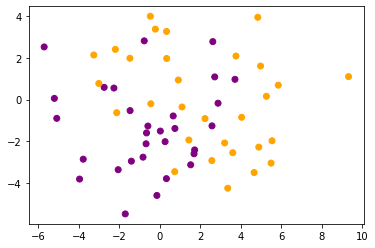

In [9]:
# Generate two Gaussian "blobs" (not linearly separable):
from sklearn.datasets import make_blobs
Xs,ys=make_blobs(n_samples=60,n_features=2,centers=[[3,0],[-1,-1]],cluster_std=[2.5,2.3])
ys=ys*2-1
colors=['orange' if y<0 else 'purple' for y in ys]
plt.scatter(Xs[:,0],Xs[:,1],color=colors)
plt.show()

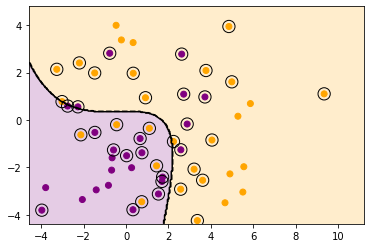

In [10]:
from sklearn.svm import SVC
model=SVC(C=1,kernel='rbf') 
model.fit(Xs,ys)
visualize_svm(model,Xs,ys,True,['orange','purple'],axis=False,margins=False)

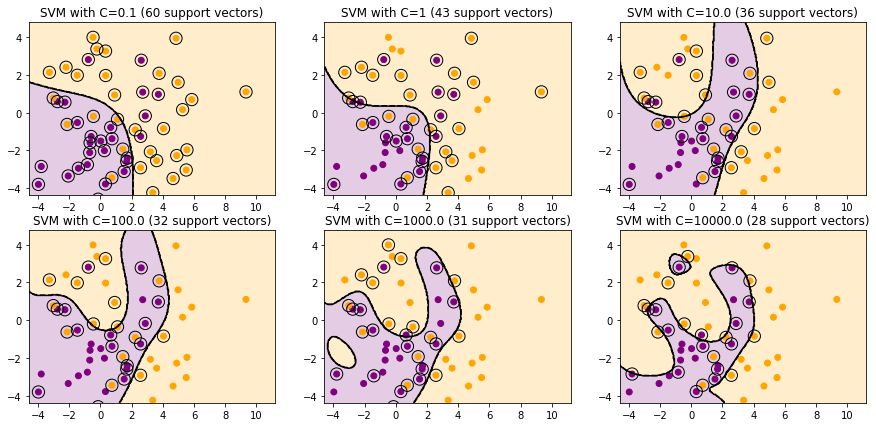

In [11]:
# Vary the value of C:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(15,7))
cs=[1e-1,1,1e1,1e2,1e3,1e4]
models={}
for i,c in enumerate(cs):
    models[c]=SVC(C=c,kernel='rbf')
    models[c].fit(Xs,ys)
    visualize_svm(models[c],Xs,ys,True,['orange','purple'],axes[i//3,i%3],margins=False)
    axes[i//3,i%3].set_title(f"SVM with C={c} ({len(models[c].support_vectors_)} support vectors)")

Now, we will undersatnd the role of $\gamma$. Again, recall that the RBF kernel is defined as $K(x_1,x_2)=\exp\left(-\gamma\lVert x_1-x_2\rVert^2\right)$. What effect does $\gamma$ have? 

Fix some $C$ and $\gamma$; let $S_{\gamma}=\{x_i\colon \alpha^{*}_i\ne 0\}$ be the set of support vectors of an SVC fitted with parameters $C$ and $\gamma$, so that the prediction function is $f^{*}(x)=b+w^{*}_{\gamma}x=b+\sum_{x_i\in S_{\gamma}}\alpha^{*}_iy_iK(x_i,x)$. Using the definition of the kernel, we get $f^{*}(x)=b+\sum_{x_i\in S_{\gamma}}\alpha^{*}_iy_i\exp\left(-\gamma\lVert x-x_i\rVert^2\right)$, meaning that $K(x,x_i)$ "weighs" the contributions of different support vectors $x_i$ to the final prediction (sum) based on their distance $\lVert x-x_i\rVert$ to the input $x$. While it is clear that, for a fixed $\gamma$, closer support vectors are contributing more because their associated $K(x,x_i)=\exp\left(-\gamma\lVert x-x_i\rVert^2\right)$ is larger, something more is true; ***when $\gamma$ is high, the prediction function places disproportionately more weight on the closest support vactors compared to more distant support vectors than it does at smaller values of $\gamma$***. Consider an example: let $\lVert x-x_1\rVert=d_1^2$ and $\lVert x-x_2\rVert=d_2^2$ and assume $d_1>d_2$, i.e. $x_2$ is closer to $x$ than $x_1$. Then, the proportion of "RBF weights" of $x_1$ to $x_2$ is

$$
\frac{K(x,x_1)}{K(x,x_2)}=\frac{\exp\left(-\gamma\lVert x-x_1\rVert^2\right)}{\exp\left(-\gamma\lVert x-x_2\rVert^2\right)}=\frac{\exp\left(-\gamma d_1^2\right)}{\exp\left(-\gamma d_2^2\right)}=\exp\left(-\gamma\left(d_1^2-d_2^2\right)\right)=\exp\left(d_1^2-d_2^2\right)^{-\gamma},
$$

which means that the proportion dwindles exponentially with $\gamma$. Thus, should support vectors be in positions $x_1$ and $x_2$, the closer support vector $x_2$ will dominate $x_1$ more brutally for larger values of $\gamma$. Here is a graph of $e^{-x^2\gamma}$ for several values of $\gamma$:

![alt text](rbf-kernel.png "RBF-Kernel")

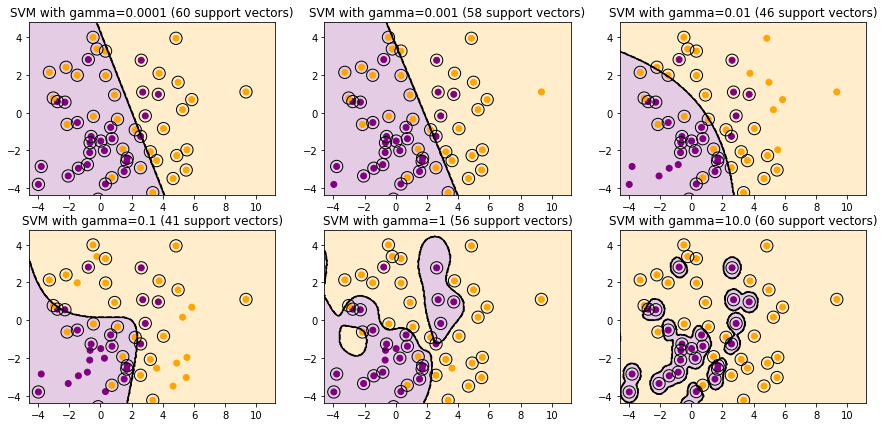

In [12]:
# Vary the value of C:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(15,7))
gammas=[1e-4,1e-3,1e-2,1e-1,1,1e1]
models={}
for i,gamma in enumerate(gammas):
    models[gamma]=SVC(C=1,kernel='rbf',gamma=gamma)
    models[gamma].fit(Xs,ys)
    visualize_svm(models[gamma],Xs,ys,True,['orange','purple'],axes[i//3,i%3],margins=False)
    axes[i//3,i%3].set_title(f"SVM with gamma={gamma} ({len(models[gamma].support_vectors_)} support vectors)")

### *SVM with Polynomial Kernel*
A polynomial kernel with degree $d$ (```degree```; defaults to 3) and coefficient $c$ (```coef0```; defaults to 0) is defined as $K(x_1,x_2)=(x_1x_2+c)^d$. The degree parameter $d$ controls the flexibility of the decision boundary, allowing for the discovery of more complex relationships between the transformed features. The coefficient $c$ shifts the emhasis between high and low order terms of the polynomial; lower values of $c$ encourage focus on higher order terms, while larger values empasize lower order interactions.

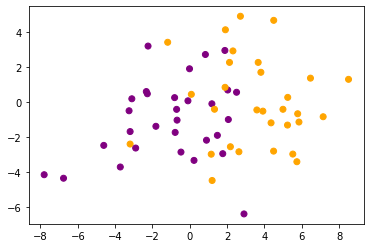

In [13]:
# Generate two Gaussian "blobs" (not linearly separable):
from sklearn.datasets import make_blobs
Xs,ys=make_blobs(n_samples=60,n_features=2,centers=[[3,0],[-1,-1]],cluster_std=[2.5,2.3])
ys=ys*2-1
colors=['orange' if y<0 else 'purple' for y in ys]
plt.scatter(Xs[:,0],Xs[:,1],color=colors)
plt.show()

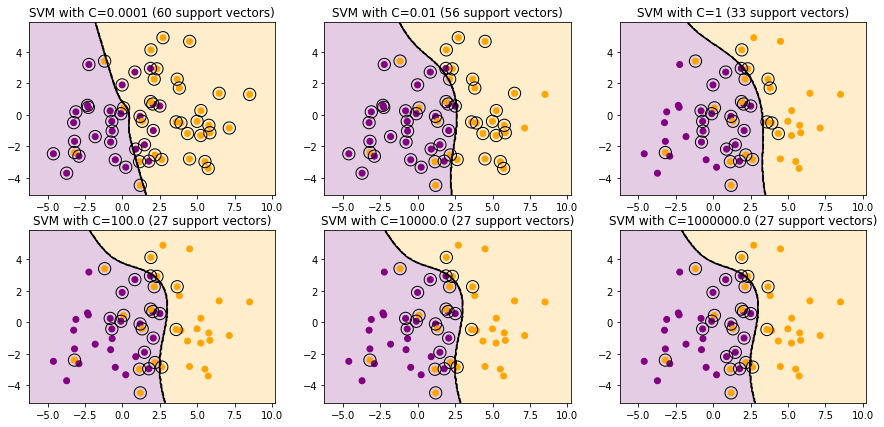

In [14]:
# Vary the value of C:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(15,7))
cs=[1e-4,1e-2,1,1e2,1e4,1e6]
models={}
for i,c in enumerate(cs):
    models[c]=SVC(C=c,kernel='poly')
    models[c].fit(Xs,ys)
    visualize_svm(models[c],Xs,ys,True,['orange','purple'],axes[i//3,i%3],margins=False)
    axes[i//3,i%3].set_title(f"SVM with C={c} ({len(models[c].support_vectors_)} support vectors)")

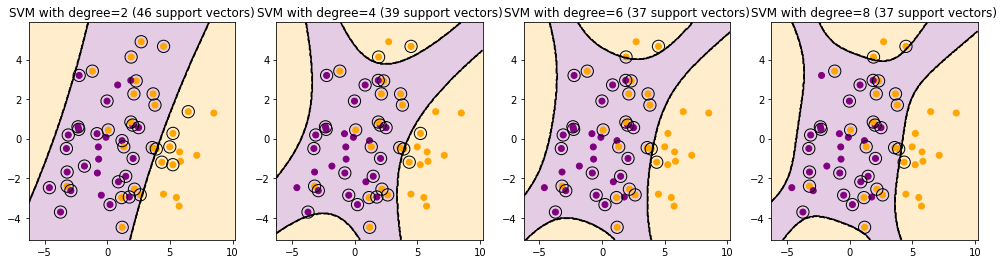

In [15]:
# Vary the value of d:
fig,axes=plt.subplots(nrows=1,ncols=4,figsize=(17,4))
degs=[2,4,6,8]
models={}
for i,deg in enumerate(degs):
    models[deg]=SVC(C=1,kernel='poly',degree=deg)
    models[deg].fit(Xs,ys)
    visualize_svm(models[deg],Xs,ys,True,['orange','purple'],axes[i%4],margins=False)
    axes[i%4].set_title(f"SVM with degree={deg} ({len(models[deg].support_vectors_)} support vectors)")

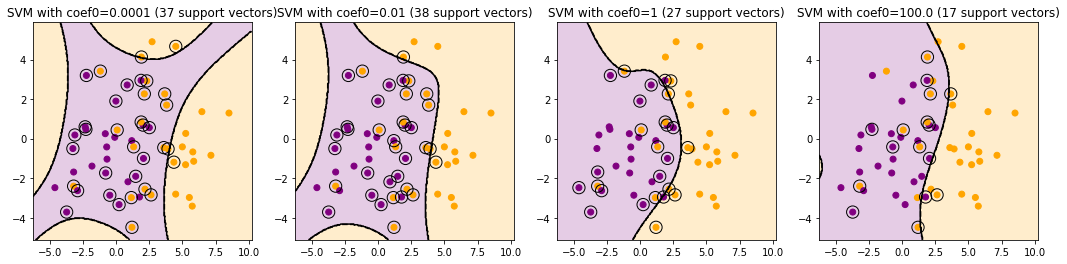

In [16]:
# Vary the value of c:
fig,axes=plt.subplots(nrows=1,ncols=4,figsize=(18,4))
cs=[1e-4,1e-2,1,1e2]
models={}
for i,c in enumerate(cs):
    models[c]=SVC(C=1,kernel='poly',degree=6,coef0=c)
    models[c].fit(Xs,ys)
    visualize_svm(models[c],Xs,ys,True,['orange','purple'],axes[i%4],margins=False)
    axes[i%4].set_title(f"SVM with coef0={c} ({len(models[c].support_vectors_)} support vectors)")

### *Elections 2016 Revisited*

In [17]:
# Load and normalize the data:
train=pd.read_csv('train_elections.csv',sep=',',index_col=0)
test=pd.read_csv('test_elections.csv',sep=',',index_col=0)
train_X=train.iloc[:,:-2]
test_X=test.iloc[:,:-2]
train_y=train.trumpWinner.astype(int).apply(lambda x: x*2-1)
test_y=test.trumpWinner.astype(int).apply(lambda x: x*2-1)
scaler=MinMaxScaler()
train_X=pd.DataFrame(scaler.fit_transform(train_X),index=train_X.index,columns=train_X.columns)
test_X=pd.DataFrame(scaler.transform(test_X),index=test_X.index,columns=test_X.columns)

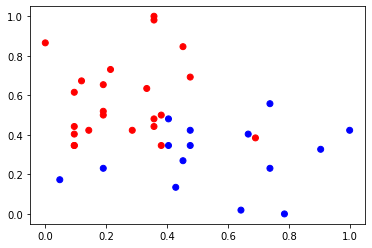

In [18]:
# Choose two features and produce a scatter plot:
features=["trump","gun"]
color=['blue' if y<0 else 'red' for y in train_y]
plt.scatter(train_X.trump,train_X.gun,color=color) 
plt.show()

In [19]:
# Fit an SVC model:
model=SVC(C=10,kernel='linear')
model.fit(train_X.loc[:,features],train_y)

SVC(C=10, kernel='linear')

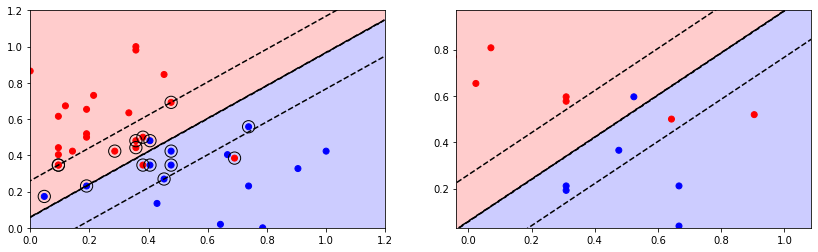

In [20]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(14,4))
visualize_svm(model,train_X.loc[:,features].to_numpy(),train_y,True,margins=True,axis=axes[0])
visualize_svm(model,test_X.loc[:,features].to_numpy(),test_y,False,margins=True,axis=axes[1])

In [21]:
# Fetch predictions:
preds=pd.DataFrame(test_y)
preds["predicted"]=model.predict(test_X.loc[:,features])
preds["correct?"]=(preds["predicted"]==preds["trumpWinner"]).astype(int)
preds.T

,CA,DE,ID,IN,MI,MS,NV,NY,PA,RI,TN,UT,VT
trumpWinner,-1,-1,1,1,1,1,-1,-1,1,-1,1,1,-1
predicted,-1,-1,1,1,-1,1,1,-1,-1,-1,1,1,-1
correct?,1,1,1,1,0,1,0,1,0,1,1,1,1


### *Linear Separability Test?*
Is there a pair of features in the dataset such that the projection of the data is linearly separable?
To determine this, fit a hard-margin SVM on the projected data for every pair of features. How large should $C$ be? Can we find a lower bound on $C$ by potentially sacrificing some predetermined precision $\epsilon>0$?

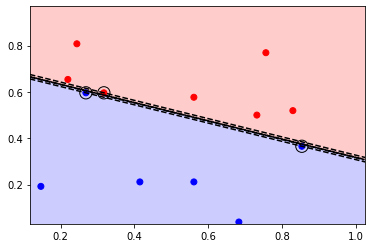

margin=0.017896271759922325


In [ ]:
from itertools import combinations
combinations=combinations(train_X.columns,2)
for features in combinations:
    model=SVC(C=1e10,kernel='linear')
    model.fit(test_X.loc[:,features],test_y)
    predictions=model.predict(test_X.loc[:,features])
    if not sum(predictions!=test_y):
        visualize_svm(model,test_X.loc[:,features].to_numpy(),test_y,support_vectors=True,margins=True)
        print(f'margin={2/np.sqrt(np.dot(model.coef_[0],model.coef_[0]))}')